In [1]:
from __future__ import absolute_import, division, print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [2]:
imdb = tf.keras.datasets.imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    path='imdb.npz',
    num_words=None,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3
)
word_index = imdb.get_word_index(path='imdb_word_index.json')

In [3]:
idx = np.argwhere(y_train>0)
np.random.seed(2020) # so it is repeatable, which is definitely a wise thing
np.random.shuffle(idx) 
idxs = idx[:round(len(idx)*.1)] 
y_trains = y_train[idxs]
x_trains = x_train[idxs]

In [4]:
idxn = np.argwhere(y_train==0)
x_train0 = x_train[idxn]
y_train0 = y_train[idxn]

In [5]:
x_train_new = np.concatenate((x_train0, x_trains), axis=None)
y_train_new = np.concatenate((y_train0, y_trains), axis=None)

In [6]:
x_trains_os = np.tile(x_trains, (10,1)) # oversampling up to 10x
y_trains_os = np.tile(y_trains, (10,1))

In [7]:
x_train_assembled = np.concatenate((x_train0, x_trains_os), axis = None)
y_train_assembled = np.concatenate((y_train0, y_trains_os), axis = None)

In [8]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(x_train_assembled,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=256)

test_data = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=256)

In [9]:
vocab_size = len(word_index)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          5669376   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 5,883,521
Trainable params: 5,883,521
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

### Cross Validation
It is a good practice to set up a portion of training data for cross validation at the end of each training epoch. This helps us identify proper training epochs and prevent overfitting by memorizing training data.

In [11]:
idx = np.arange(len(train_data))
np.random.shuffle(idx)

idxs = idx[:round(len(idx)*.8)] 
partial_x_train = train_data[idxs]
partial_y_train = y_train_assembled[idxs]

x_val = np.delete(train_data, idxs.tolist(), axis=0) # select remaining as cross validation data
y_val = np.delete(y_train_assembled, idxs.tolist(), axis=0)


In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/40


W0309 16:16:58.345654 140521047328576 deprecation.py:323] From /home/bert/.local/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


20000/20000 [==============================] - 71s 4ms/sample - loss: 0.6331 - acc: 0.6513 - val_loss: 0.4467 - val_acc: 0.8090
Epoch 2/40
20000/20000 [==============================] - 69s 3ms/sample - loss: 0.1590 - acc: 0.9422 - val_loss: 0.0491 - val_acc: 0.9832
Epoch 3/40
20000/20000 [==============================] - 70s 4ms/sample - loss: 0.0117 - acc: 0.9973 - val_loss: 0.0273 - val_acc: 0.9932
Epoch 4/40
20000/20000 [==============================] - 71s 4ms/sample - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0486 - val_acc: 0.9898
Epoch 5/40
20000/20000 [==============================] - 71s 4ms/sample - loss: 3.1141e-04 - acc: 0.9999 - val_loss: 0.0382 - val_acc: 0.9922
Epoch 6/40
20000/20000 [==============================] - 72s 4ms/sample - loss: 1.0943e-04 - acc: 1.0000 - val_loss: 0.0393 - val_acc: 0.9920
Epoch 7/40
20000/20000 [==============================] - 72s 4ms/sample - loss: 6.7331e-05 - acc: 1.0000 - val_loss: 0.0457 - val_acc: 0.9910
Epoch 8/40
20000/20000 [==

In [13]:
results = model.evaluate(test_data, y_test)

9184/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

InvalidArgumentError:  indices[31,33] = 88584 is not in [0, 88584)
	 [[node sequential/embedding/embedding_lookup (defined at /home/bert/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_7369]

Function call stack:
distributed_function


In [14]:
print(model.metrics_names)

['loss', 'acc']


In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Lets take a look at training process to make sure the model is improving through training epochs.

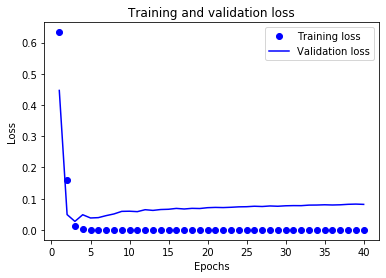

In [16]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

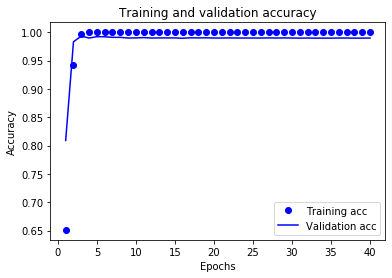

In [17]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
predicted = model.predict(test_data)
#the above is just to show where the situation actually fails, which means here

InvalidArgumentError:  indices[31,33] = 88584 is not in [0, 88584)
	 [[node sequential/embedding/embedding_lookup (defined at /home/bert/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_15469]

Function call stack:
distributed_function


### From here forward nothing works
which means, what changed in model.predict? how should I change the data?
```python
InvalidArgumentError:  indices[31,33] = 88584 is not in [0, 88584)
	 [[node sequential/embedding/embedding_lookup (defined at .local/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_15469]

Function call stack:
distributed_function
```

In [ ]:
predicted[predicted > 0.5] = 1
predicted[predicted <= 0.5] = 0
predictedf = predicted.flatten().astype(int)

df3 = pd.DataFrame(data=predictedf, columns=['predicted'])
refdf = pd.DataFrame(data=y_test, columns=['actual'])

y_actu = pd.Series(refdf['actual'], name='ACTUAL')
y_pred = pd.Series(df3['predicted'], name='PREDICTED')
predicted_results = y_pred.tolist()
truth = y_actu.tolist()

dl_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [ ]:
dl_confusion

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(truth, predicted_results)
print(report)